In [2]:
import numpy as np
import os
from tqdm import tqdm
from PIL import Image
from matplotlib.pyplot import imshow
import math
import sklearn

import dscribe
import dscribe.descriptors
from dscribe.descriptors import SOAP

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from collections import namedtuple
from ase.io import read
from ase.build import molecule
from ase import Atoms, Atom
from ase.visualize import view
from ase.geometry.analysis import Analysis
import plotly.graph_objects as go
from ase.data import vdw_radii
from ase.data.colors import cpk_colors, jmol_colors
import matplotlib.pyplot as plt

from soap_generation.alignment import align_elements
from soap_generation.augment import augment_elements

from ase.io import read
from ase.build import molecule
from ase import Atoms, Atom
from ase.visualize import view
from ase.geometry.analysis import Analysis
import plotly.graph_objects as go
from ase.data import vdw_radii
from ase.data.colors import cpk_colors, jmol_colors

In [2]:
from decoder.soap import SOAPDecoder

species = ["H","C","N","O","F","P","S","Cl","As","Br","I","Ir"]

rcut = 2
nmax = 3
lmax = 3

decoder = SOAPDecoder(rcut=rcut, nmax=nmax, lmax=lmax)

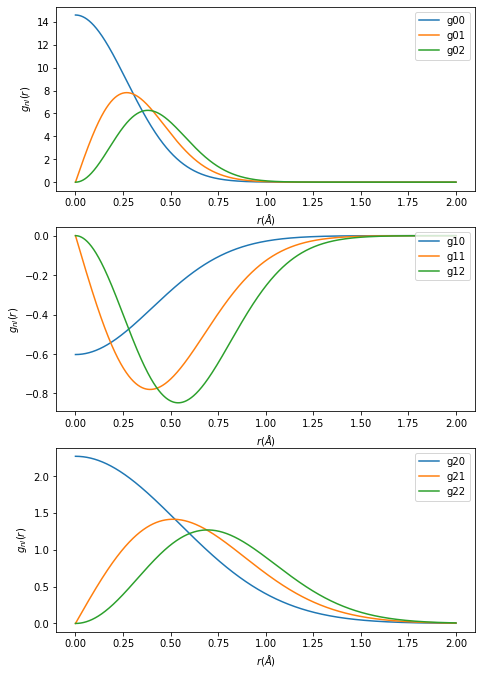

In [45]:
x = np.linspace(0, rcut, 1000)

fig, axs = plt.subplots(3)

l = 0
axs[0].plot(x, decoder.radial_basis(x, l, 0), label="g00")
axs[0].plot(x, decoder.radial_basis(x, l, 1), label="g01")
axs[0].plot(x, decoder.radial_basis(x, l, 2), label="g02")
axs[0].set_xlabel('$r(\AA)$')
axs[0].set_ylabel('$g_{nl}(r)$')
axs[0].legend(loc="upper right")

l = 1
axs[1].plot(x, decoder.radial_basis(x, l, 0), label="g10")
axs[1].plot(x, decoder.radial_basis(x, l, 1), label="g11")
axs[1].plot(x, decoder.radial_basis(x, l, 2), label="g12")
axs[1].set_xlabel('$r(\AA)$')
axs[1].set_ylabel('$g_{nl}(r)$')
axs[1].legend(loc="upper right")

l = 2
axs[2].plot(x, decoder.radial_basis(x, l, 0), label="g20")
axs[2].plot(x, decoder.radial_basis(x, l, 1), label="g21")
axs[2].plot(x, decoder.radial_basis(x, l, 2), label="g22")
axs[2].set_xlabel('$r(\AA)$')
axs[2].set_ylabel('$g_{nl}(r)$')
axs[2].legend(loc="upper right")

fig.set_size_inches(7.5, 11.5)
plt.show()

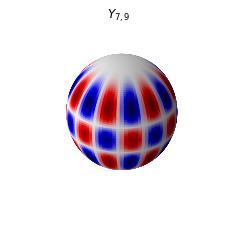

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.special import sph_harm

phi = np.linspace(0, np.pi, 100)
theta = np.linspace(0, 2*np.pi, 100)
phi, theta = np.meshgrid(phi, theta)

# The Cartesian coordinates of the unit sphere
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

m, l = 7, 9

# Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
fcolors = sph_harm(m, l, theta, phi).real
fmax, fmin = fcolors.max(), fcolors.min()
fcolors = (fcolors - fmin)/(fmax - fmin)

# Set the aspect ratio to 1 so our sphere looks spherical
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.seismic(fcolors))
# Turn off the axis planes
ax.set_axis_off()
plt.title("$Y_{%i,%i}$" % (m,l))
plt.show()

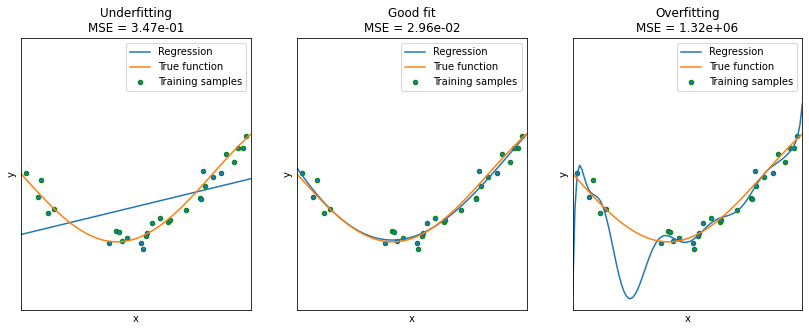

In [5]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


def true_fun(X):
    return np.sin(-1.2 * np.pi * X)

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 13]
title = ["Underfitting", "Good fit", "Overfitting"]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Regression")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='g', s=20, label="Training samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("{}\nMSE = {:.2e}".format(
        title[i], -scores.mean()))
plt.show()

In [37]:
from soap_generation.alignment import align_elements

fig = go.Figure()

element = read("/Users/leon/Files/bachelor-thesis/data/coordinates_molSimplify/ir_tbp_1_dft-asme3_1_dft-nme3_1_dft-co_1_dft-icn_1_smi1_1_s_1.xyz")

element = align_elements([element])[0]

for position, atomic_number in zip(element.get_positions(), element.get_atomic_numbers()):
    x1 = position[0]
    y1 = position[1]
    z1 = position[2]
    size = np.nan_to_num(vdw_radii[atomic_number]) #* 0.3

    if size == 0:
        size = 2

    phi = np.linspace(0, 2*np.pi, 30)
    theta = np.linspace(-np.pi/2, np.pi/2, 30)
    phi, theta=np.meshgrid(phi, theta)

    x = np.cos(theta) * np.sin(phi) * size + x1
    y = np.cos(theta) * np.cos(phi) * size + y1
    z = np.sin(theta) * size + z1    
    color_string = "rgb(" + str(jmol_colors[atomic_number][0] * 230) + "," + str(jmol_colors[atomic_number][1] * 230) + "," + str(jmol_colors[atomic_number][2] * 230) + ")"

    fig.add_trace(go.Mesh3d({'x':x.flatten(), 
                                'y':y.flatten(),
                                'z':z.flatten(),
                                'alphahull': 0, 
                                'color': color_string,
                            }))
x= np.linspace(-7, 6, 75)
y= np.linspace(-6, 6, 100)
z= -0.5 * np.ones((100,75))
mycolorscale = [[0, '#aa9ce2'],
                [1, '#aa9ce2']]
fig.add_trace(go.Surface(x=x, y=y, z=z, colorscale=mycolorscale, showscale=False, opacity=0.6))
    
fig.update_layout(
    height=500,
    showlegend=False, 
    scene = dict(
        xaxis = dict(title=r'x'),
        yaxis = dict(title=r'y'),
        zaxis = dict(title=r'z')
    )
)

fig.show()

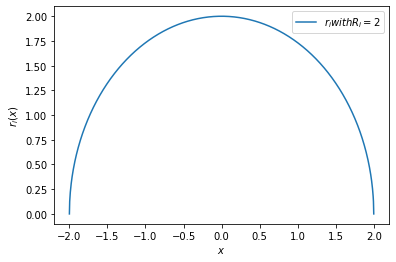

In [50]:
x = np.linspace(-2, 2, 1000)


def r(x):
    return np.sqrt(4 - x**2)

plt.plot(x, r(x), label="$r_i  with  R_i=2$")
plt.xlabel('$x$')
plt.ylabel('$r_i(x)$')
plt.legend(loc="upper right")

#fig.set_size_inches(7.5, 11.5)
plt.show()

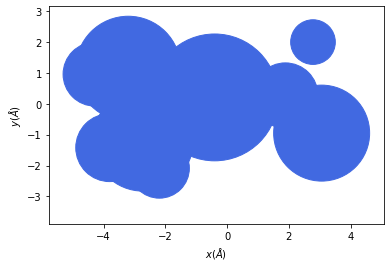

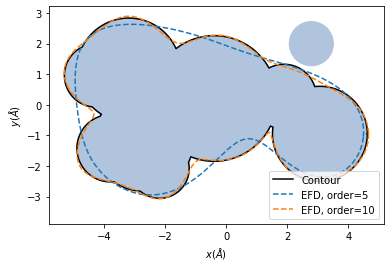

In [168]:
from mendeleev import element
from feature_generation.create_slices import slice_to_contour
from feature_generation.alignment import align_catalyst
from pyefd import elliptic_fourier_descriptors, normalize_efd, calculate_dc_coefficients, reconstruct_contour

Atom = namedtuple('Atom', ['element', 'location', 'radius'])


def get_radius(atom):
    """
    Getting radii from mendeleev seems to be reallly slow. Buffer them to speed up exectuion
    """
    radius = element(atom).vdw_radius / 100
    return radius


def radius_at_height(radius, height):
    """
    Returns the radius of a sphere at a height.
    Height is relative to the center of the sphere.
    """
    if radius == 0:
        return 0

    relativeHeight = (height - (radius)) / radius
    if relativeHeight <= -1 or relativeHeight >= 1:
        return 0
    return np.sin(np.arccos(relativeHeight)) * radius

atoms = []
for lineidx, line in enumerate(open("/Users/leon/Files/bachelor-thesis/data/coordinates_TS/ir_tbp_1_dft-asme3_1_dft-nme3_1_dft-co_1_dft-icn_1_smi1_1_s_1_TS.xyz", "r")):
    if lineidx >= 2:
        elem = line.split()[0].capitalize()
        location = np.array([float(line.split()[1]), float(
            line.split()[2]), float(line.split()[3])])
        radius = get_radius(elem)
        atoms.append(Atom(elem, location, radius))

aligned_atoms = align_catalyst(atoms)

fig, ax = plt.subplots()

for atom in aligned_atoms:
    radius = radius_at_height(atom.radius, 3-atom.location[2])
    c1 = plt.Circle((atom.location[0], atom.location[1]), radius, color='royalblue')
    ax.add_patch(c1)

plt.xlabel('$x (\AA)$')
plt.ylabel('$y (\AA)$')
plt.axis('equal')
#fig.set_size_inches(7.5, 11.5)
plt.show()




atoms = []
for lineidx, line in enumerate(open("/Users/leon/Files/bachelor-thesis/data/coordinates_TS/ir_tbp_1_dft-asme3_1_dft-nme3_1_dft-co_1_dft-icn_1_smi1_1_s_1_TS.xyz", "r")):
    if lineidx >= 2:
        elem = line.split()[0].capitalize()
        location = np.array([float(line.split()[1]), float(
            line.split()[2]), float(line.split()[3])])
        radius = get_radius(elem)
        atoms.append(Atom(elem, location, radius))

aligned_atoms = align_catalyst(atoms)

fig, ax = plt.subplots()

for atom in aligned_atoms:
    radius = radius_at_height(atom.radius, 3-atom.location[2])
    c1 = plt.Circle((atom.location[0], atom.location[1]), radius, color='lightsteelblue')
    ax.add_patch(c1)

#plt.show()

slice_no = 6

slices = slice_to_contour(aligned_atoms, 1,
                         -3, 10, 0.01, ["X"])

s = [1] * len(slices[slice_no][0])
plt.plot(*zip(*slices[slice_no][0]), 'k', label="Contour")

fourier = elliptic_fourier_descriptors(slices[slice_no][0], 5)
locus = calculate_dc_coefficients(slices[slice_no][0])
contour = reconstruct_contour(fourier, locus)
s = [1] * len(contour)
plt.plot(*zip(*contour.tolist()), '--', label="EFD, order=5")

fourier = elliptic_fourier_descriptors(slices[slice_no][0], 10)
locus = calculate_dc_coefficients(slices[slice_no][0])
s = [1] * len(contour)
contour = reconstruct_contour(fourier, locus)

plt.plot(*zip(*contour.tolist()), '--', label="EFD, order=10")

plt.xlabel('$x (\AA)$')
plt.ylabel('$y (\AA)$')
plt.axis('equal')
plt.legend(loc="lower right")

#fig.set_size_inches(7.5, 11.5)
plt.show()

(15, 40, 1)
(15, 300)


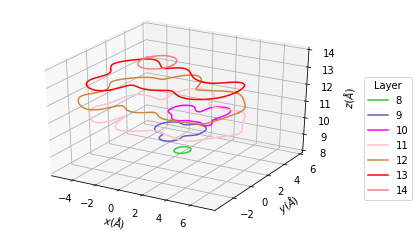

In [3]:
from pyefd import elliptic_fourier_descriptors, normalize_efd, calculate_dc_coefficients, reconstruct_contour, reconstruct_contour_from_features
import pandas as pd
import plotly.express as px
import plotly.express as px


shape = np.load("../data/fourier/ir_tbp_1_dft-pme3_1_dft-py_1_dft-co_1_dft-cch_1_smi1_1_s_1_ts-map.npy")
print(shape.shape)
x = []
y = []
color = []
c_mlb = []
z = []
k = 0
channels = 1
for slice_z in shape:    
    for channel in range(channels):
        f1 = np.array([x[channel] for x in slice_z.reshape(40,channels)])
        #print(f1)
        #f1 = f1.reshape(10,4)
        
        f1, locus = reconstruct_contour_from_features(f1, include_rotation=False)
        points = reconstruct_contour(f1, locus)

        x.append(np.array([p[0] for p in points]))
        y.append(np.array([p[1] for p in points]))
        
        #color.append([slice_z] * len(points))

        ## Remove unnecessary empty layers
        if np.max(f1) != 0:
            color.append([k] * len(points))
            z.append([k] * len(points))
        else:
            z.append([10] * len(points))
            color.append(["other layers"] * len(points))
        c_mlb.append([k] * len(points))
            
    k += 1
        


x = np.array(x)
print(x.shape)
y = np.array(y)
z = np.array(z)
color = np.array(color)


df = pd.DataFrame(dict(
    X=x.flatten(), 
    Y=y.flatten(), 
    Z=z.flatten(),
    Layer=color.flatten()
))


fig = px.line_3d(df, x="X", y="Y", z="Z", color="Layer")

fig.update_layout(
    width=600,
    height=600,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    showlegend=True
)

#print(px.line_3d(df, x="X", y="Y", z="Z"))
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99
))
fig.show()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b', 'c', 'm','y','sienna','orange','limegreen','slateblue','fuchsia','pink','peru','r', 'lightcoral', 'crimson']
for k in range(len(x)):
    if np.amax(x[k])>0:
        ax.plot3D(x[k], y[k], z[k], colors[k], label=str(k));

ax.set_xlabel('$x (\AA)$')
ax.set_ylabel('$y (\AA)$')
ax.set_zlabel('$z (\AA)$')
plt.legend(loc="upper left", title="Layer", bbox_to_anchor=(1.05, 0.7))
plt.show()